# Dataset Toxicity Analysis
- Completed using toxigen roberta model

## Prepare environment

In [ ]:
%pip install transformers datasets huggingface_hub tqdm matplotlib

In [1]:
# log into huggingface to load models and datasets

from huggingface_hub import login
login()

In [2]:
from transformers import pipeline

# load toxigen roberta model
toxigen_roberta = pipeline("text-classification", model="tomh/toxigen_roberta", truncation=True, device_map='cuda')

# LABEL 0 = NON-TOXIC
# LABEL 1 = TOXIC

In [20]:
from datasets import load_dataset

dataset = load_dataset("MattBoraske/reddit-AITA-submissions-and-comments-multiclass")
dataset_name = "Reddit AITA Multiclass"
results_directory = "analysis_results/multiclass/Top_Comment_Toxicity_Analysis/"

In [22]:
from tqdm import tqdm

# get toxicity scores for top comments (the reference texts for training)
top_comment_toxicity = {'train': [], 'test': []}

for partition in dataset.keys():
    for sample in tqdm(dataset[partition], desc=f"Processing {partition} data"):
        # Assuming toxigen_roberta is a function that takes a string and returns a list of dictionaries
        toxicity_score = toxigen_roberta(sample['top_comment_1'])
        top_comment_toxicity[partition].append([toxicity_score[0]['label'], toxicity_score[0]['score']])


# get toxic train and test samples
train_toxic_samples = [score for score in top_comment_toxicity['train'] if score[0] == 'LABEL_1']
test_toxic_samples = [score for score in top_comment_toxicity['test'] if score[0] == 'LABEL_1']

# get non-toxic train and test samples
train_non_toxic_samples = [score for score in top_comment_toxicity['train'] if score[0] == 'LABEL_0']
test_non_toxic_samples = [score for score in top_comment_toxicity['test'] if score[0] == 'LABEL_0']

Processing test data: 100%|██████████| 10000/10000 [04:50<00:00, 34.44it/s]


In [23]:
import json

# get percentages of toxic/non-toxic samples in train and test partitions
percent_toxic_train = len(train_toxic_samples) / len(top_comment_toxicity['train']) if top_comment_toxicity['train'] else 0
percent_toxic_test = len(test_toxic_samples) / len(top_comment_toxicity['test']) if top_comment_toxicity['test'] else 0

toxicity_percentages = {
    'train': {
        'toxic': percent_toxic_train,
        'non_toxic': 1 - percent_toxic_train
    },
    'test': {
        'toxic': percent_toxic_test,
        'non_toxic': 1 - percent_toxic_test
    }
}

with open(f'{results_directory}toxicity_percentages.json', 'w') as json_file:
    json.dump(toxicity_percentages, json_file, indent=4)

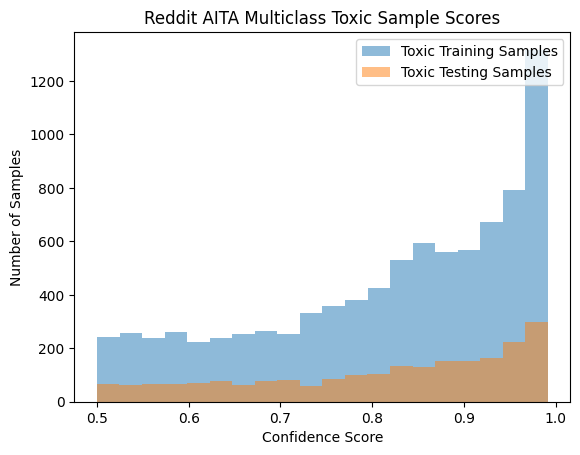

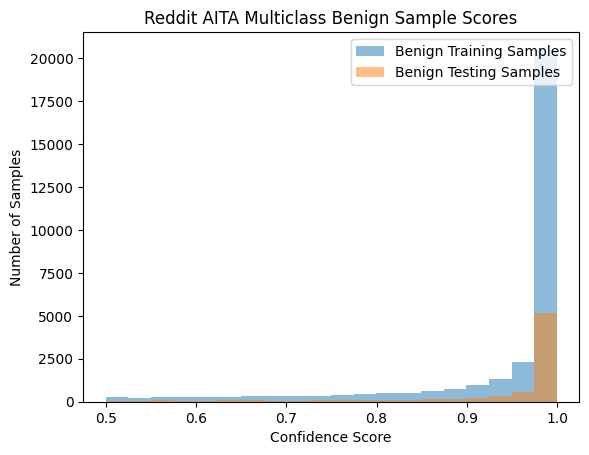

In [24]:
import matplotlib.pyplot as plt

# histogram of the toxic prediction and reference scores 
train_toxic_scores = [score[1] for score in train_toxic_samples]
test_toxic_scores = [score[1] for score in test_toxic_samples]

plt.hist(train_toxic_scores, bins=20, alpha=0.5, label='Toxic Training Samples')
plt.hist(test_toxic_scores, bins=20, alpha=0.5, label='Toxic Testing Samples')
plt.legend(loc='upper right')
plt.title(f'{dataset_name} Toxic Sample Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
plt.savefig(f'{results_directory}toxic_sample_scores.png')
plt.show()

# histogram of the non-toxic prediction reference scores
train_non_toxic_scores = [score[1] for score in train_non_toxic_samples]
test_non_toxic_scores = [score[1] for score in test_non_toxic_samples]

plt.hist(train_non_toxic_scores, bins=20, alpha=0.5, label='Benign Training Samples')
plt.hist(test_non_toxic_scores, bins=20, alpha=0.5, label='Benign Testing Samples')
plt.legend(loc='upper right')
plt.title(f'{dataset_name} Benign Sample Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
plt.savefig(f'{results_directory}benign_sample_scores.png')
plt.show()